# Part 1: Setup
Before we start, we need to prepare our environment.

For a better experience, please enable Google Colab’s TPU:

(Runtime) → (Change runtime type) → (T4 TPU) → (Save)

## 1.1 - Loading Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B-Instruct", device_map="cuda")
model = AutoModelForCausalLM.from_pretrained("unsloth/Llama-3.2-1B-Instruct", device_map="cuda")

## 1.2 - Defining Auxiliary Functions
Now, let's define some auxiliary functions to help us visualize the number of parameters of a model and do simple inferences.

In [ ]:
def print_model_parameters(model):
    """
    Prints the total number of parameters in the model.

    Args:
        model (nn.Module): The model.
    """
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_params} parameters")
    return total_params


In [ ]:
def generate_output(model, tokenizer, prompt):
    generate = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        device_map=model.device,
    )

    out = generate(
        prompt,
        max_new_tokens=64,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        use_cache=False,
    )

    return out[0]["generated_text"]

# Part 2: Working with Transformers Model Implementation
Before we jump into pruning models, we need to understand how to work with their implementations, using the transformers library.

## 2.1 - Understanding Model Architecture Implementation Structure

In a pruning process, the model structure implementation and its associated configuration are two important things to understand, since it is a process that fundamentally changes the way the network is represented and operates.

### 2.1.1 - Model Structure

The model structure is visible through a simple "print(model)". We are able to get structures of different granularities by accessing its specifics attributes and indexes.

In [ ]:
print(model)

For example: if you want to access the 5-th layer of the model, you use the following command:

In [ ]:
model.model.layers[4]  # Obs: layer index starts at 0

If you want to go even further, accessing the down projection of the 7th layer of the model for example, you access it by using:

In [ ]:
model.model.layers[6].mlp.down_proj

If you want to access the weights, you use 'weight.data' at the end of the command

In [ ]:
model.model.layers[6].mlp.down_proj.weight.data

### 2.1.2 - Model Config

Basically, the pruning of LLMs consists of removing elements (layers, attention heads, MLP neurons) from the model and *making sure the indexes are properly set* after the removal.

There is another important element when dealing with models from Hugging Face: the model config. Each model has a configuration file, consisting of a JSON that tells the transformers library of how to load the model.

If you prune the model, the config file must be updated as well to reflect the changes in the architecture. You access the config file by using the command "model.config"

In [ ]:
model.config

For us, the important elements we need to update are:


*  **intermediate_size**: if we prune the MLP within each layer;
*   **num_attention_heads** and **num_key_value_heads**: if we prune attention heads from the attention mechanism;
*   **num_hidden_layers**: if we prune layers within the model.


Consider you have removed one layers from the model. Your config file must be updated considering the new **num_hidden_layers** value. If you do not update this value, when you try the load the model in the future, it will not work, as Transformers is expecting a model with ℓ layers and the existing model has  ℓ-1 layers.



On the other side, if you prune the MLP within each layer or prune attention heads from the attention mechanism you must update **intermediate_size** and **num_attention_heads** to make Transformers able to adequately load the pruned model.

# Part 3: Pruning Layers and MLP Neurons
With the adequate setup and understanding of the model implementation, we are able to start the pruning itself.

First, let's save the total number of parameters of the original, unpruned model (sometimes referred to as "dense model"), and run an inference for a prompt. Try some prompts yourself!

In [ ]:
unpruned_model_parameters_count = print_model_parameters(model)

In [ ]:
unpruned_model_inference = generate_output(model, tokenizer, "Explain the difference between Brazil and Portugal in two sentences:")
unpruned_model_inference

## 3.1 - Layer Pruning

We will start by pruning the simplest structure within Large Language Models: the layers. As we remove every structure within each layer, we dont have to worry about updating specific indexes, so this form of pruning is very straightforward.

All we have to do is select the layer we want to remove and use the 'del' command, just as the following (in this case, we will remove the first layer):

`del model.model.layer[0]`

The function below considers a number of layers to prune OR a pruning ratio to remove layers from the LLM randomly.

In [ ]:
import torch
from typing import Optional

def prune_llama3_layers_random(
    model,
    n_layers_to_prune: Optional[int] = None,  # e.g. 5  (overrides ratio if given)
    pruning_ratio: float = 0.30,              # e.g. 0.3 → drop 30 % of layers
    seed: Optional[int] = 0,                  # set None for nondeterministic pruning
    verbose: bool = True
) -> None:
    """
    Randomly removes full decoder layers from a Llama-3.2 model (in-place).

    Parameters
    ----------
    model : LlamaForCausalLM
        Loaded model whose layers live at `model.model.layers`.
    n_layers_to_prune : int, optional
        How many layers to delete.  If None, the `pruning_ratio` is used.
    pruning_ratio : float, optional
        Fraction of layers to delete (ignored when `n_layers_to_prune` given).
    seed : int or None, optional
        RNG seed for reproducible pruning; None disables seeding.
    verbose : bool, optional
        Print a short summary when done.

    Returns
    -------
    None  (model modified in place)
    """
    layers = model.model.layers
    total_layers = len(layers)

    # Decide how many layers to drop
    if n_layers_to_prune is None:
        n_layers_to_prune = int(pruning_ratio * total_layers)

    if not (0 < n_layers_to_prune < total_layers):
        raise ValueError(
            f"`n_layers_to_prune` must be between 1 and {total_layers - 1}"
        )

    # RNG for reproducibility
    gen = torch.Generator()
    if seed is not None:
        gen.manual_seed(seed)

    # Pick layers to remove & keep
    prune_idx = torch.randperm(total_layers, generator=gen)[:n_layers_to_prune].tolist()
    keep_idx  = sorted(set(range(total_layers)) - set(prune_idx))

    # Build a fresh ModuleList with the kept layers
    kept_layers = torch.nn.ModuleList([layers[i] for i in keep_idx])

    # Replace and update config
    del model.model.layers
    model.model.layers = kept_layers

    if verbose:
        print(f"✅ Removed {n_layers_to_prune}/{total_layers} layers "
              f"(kept indices: {keep_idx}).")


Let's remove 30% of the layers of the model.


In [ ]:
prune_llama3_layers_random(model, pruning_ratio=0.3)

# Updating Model Config
print(f"Before update number of layers {model.config.num_hidden_layers}")
model.config.num_hidden_layers = len(model.model.layers)
print(f"After update number of layers {model.config.num_hidden_layers}")

Let's check the updated model structure. Pay attention to the number of layers described.


In [ ]:
print(model)

Now let's compare the output of the pruned and unpruned model and their total number of parameters.

In [ ]:
print(f"Total number of parameters of the unpruned model: {unpruned_model_parameters_count} parameters")
pruned_model_parameters_count = print_model_parameters(model)
print(f"Current pruning ratio: {1 - (pruned_model_parameters_count / unpruned_model_parameters_count)}")

In [ ]:
print(f"\n Unpruned Model Inference: {unpruned_model_inference}")
pruned_model_inference = generate_output(model, tokenizer, "Explain the difference between Brazil and Portugal in two sentences:")
print(f"\n Pruned Model Inference: {pruned_model_inference}")

The pruning process successfully reduces the number of parameters, but the generated text does not make sense. Later we will show that *a fine-tune repairs the model performance*.

## 3.2 - Pruning MLP Neurons

We will start by pruning MLP neurons from each layer of the model. We could also prune attention heads, but as the Llama 3.2 model only has 32 Query heads and 8 Key-Value head in each layer (Grouped-Query Attention), it is probably not worth to prune these structures, as the model would probably collapse. However, the removal of attention heads, specially in larger models, helps to maintain the predictive ability as the pruning ratio rises. In this sense, Mugnaini et al. (2025) propose an efficient method for the removal of these structures.

For the tutorial, we will focus our attention on MLP neurons, as these structures compose the majority of the parameter count in LLMs and are simpler to remove.

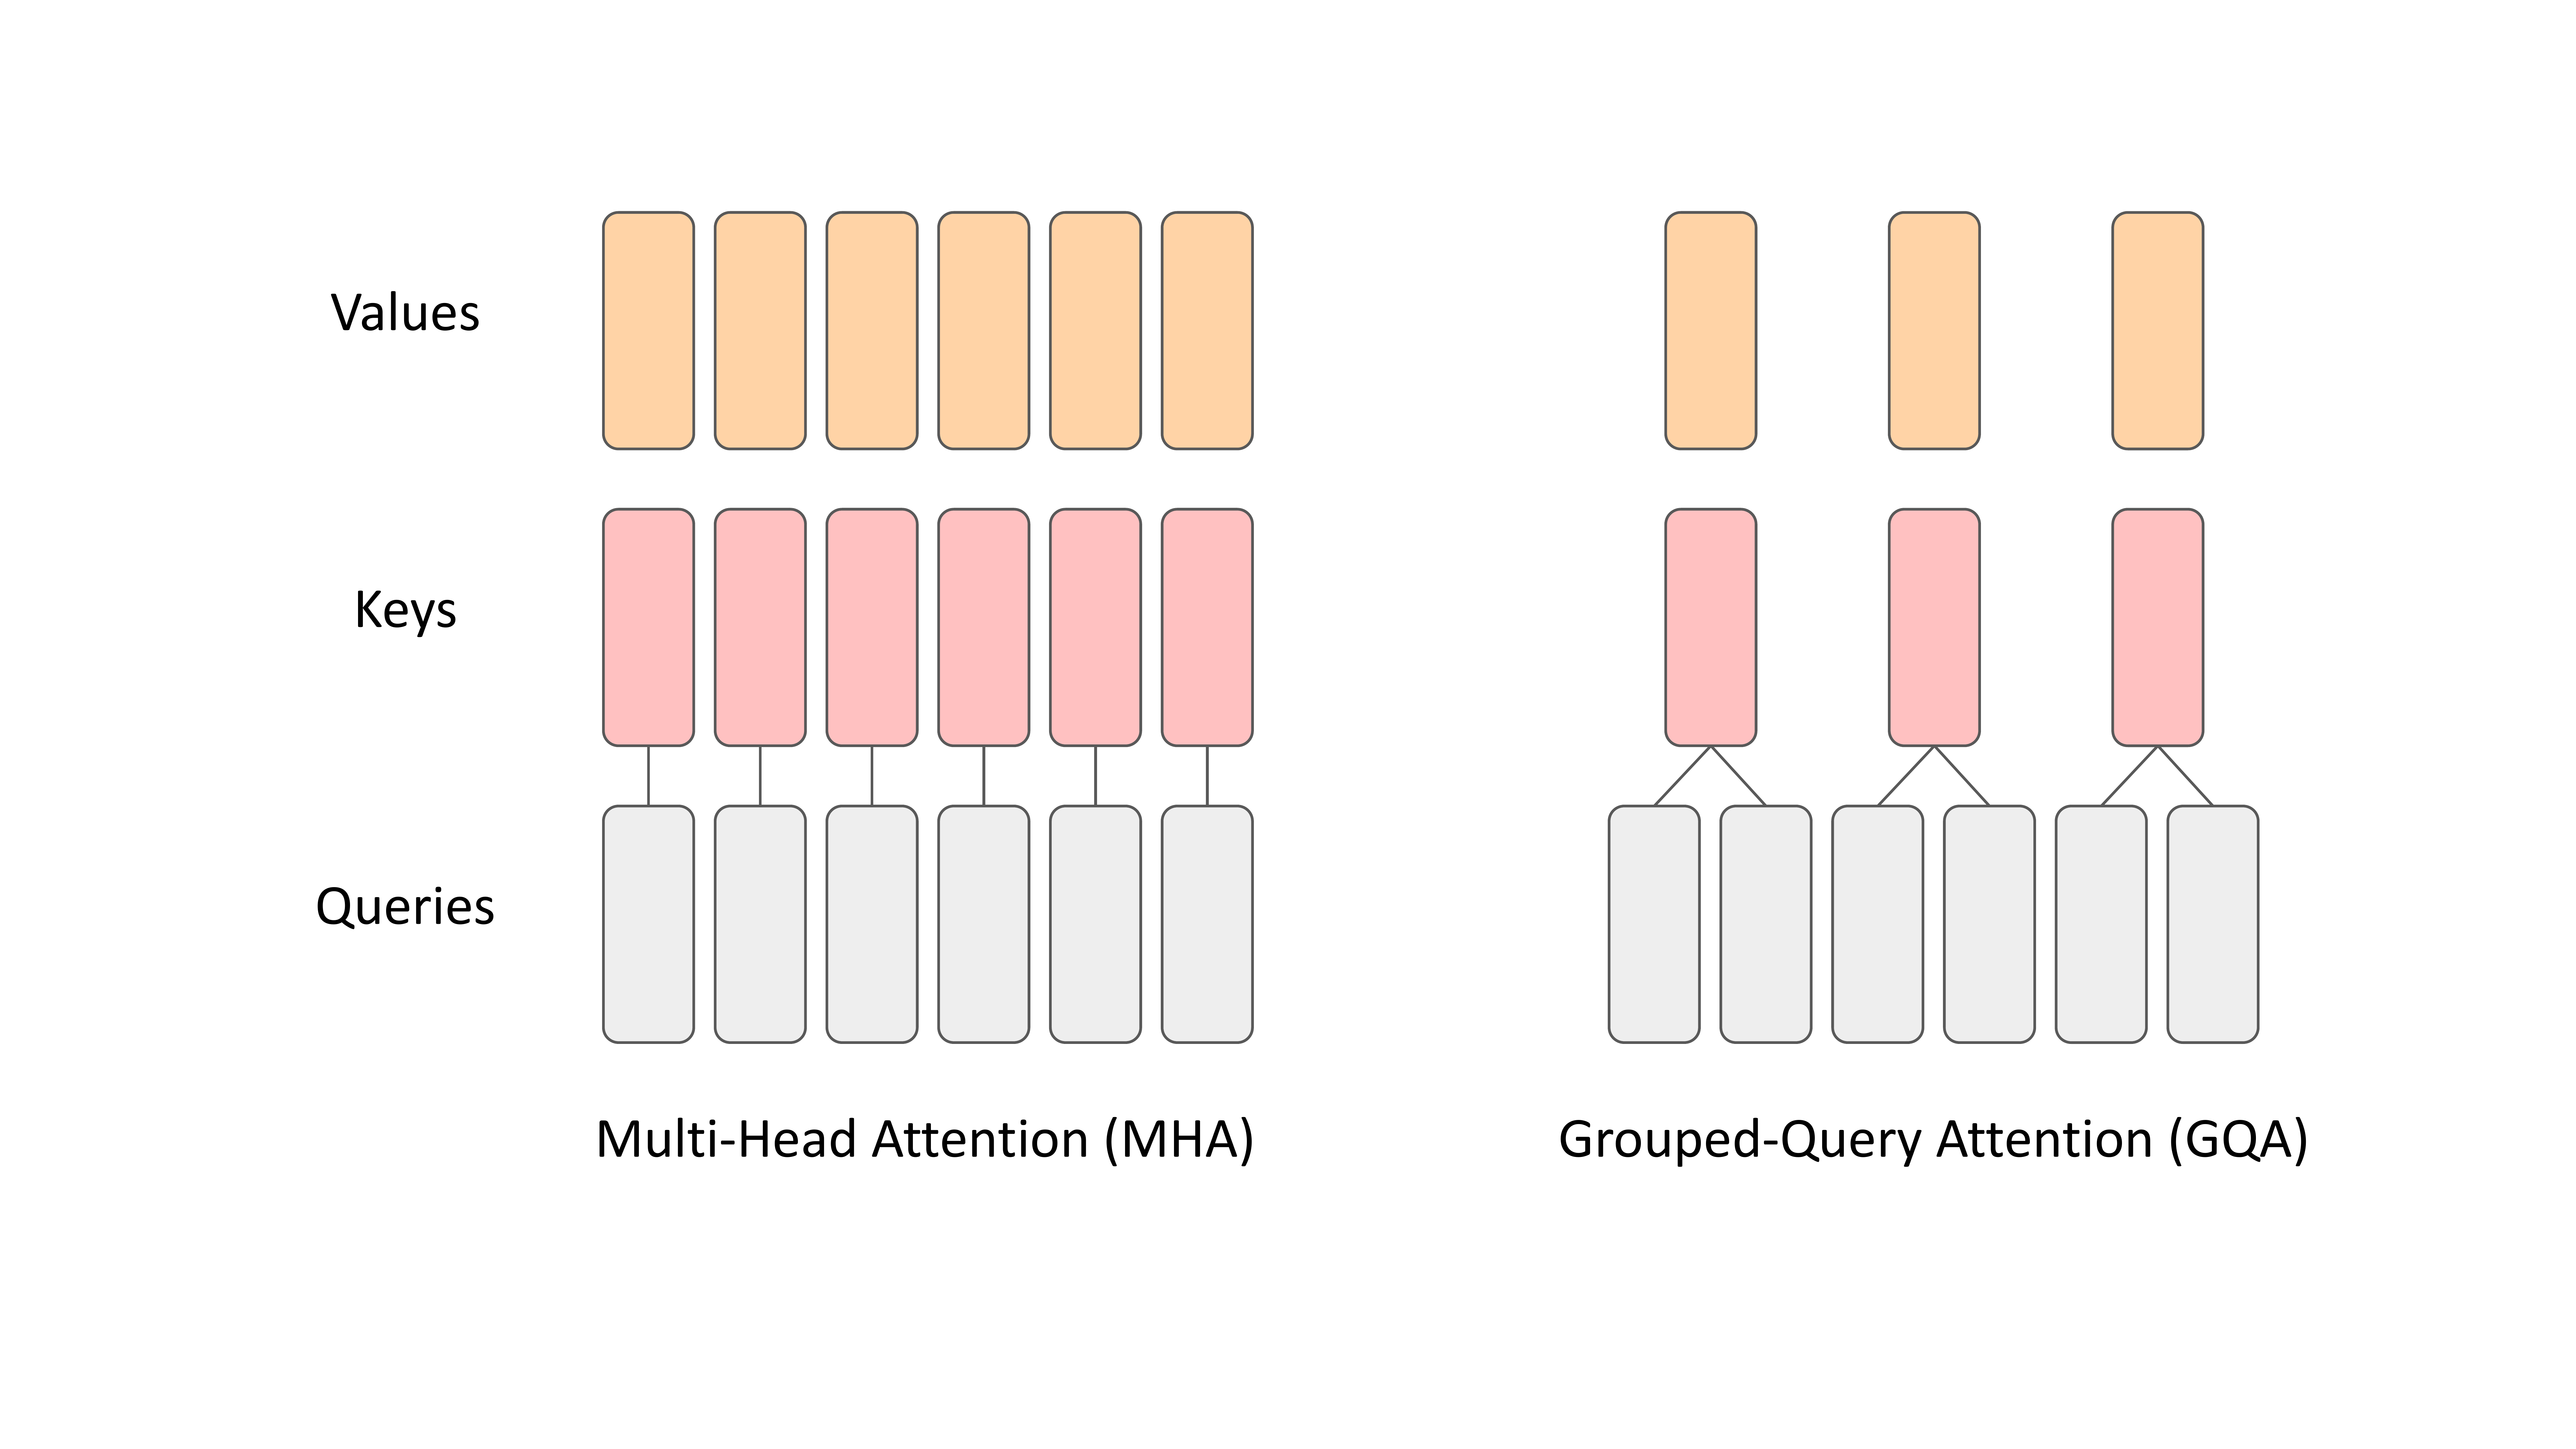

In [ ]:
import torch
from typing import Optional

def prune_llama3_mlp_random(
    model,
    pruning_ratio: float = 0.30,   # fraction of the 8192 neurons to drop
    seed: Optional[int] = 0        # set None for nondeterministic pruning
) -> None:
    """
    Randomly prunes the feed-forward block of each Llama-3 decoder layer
    *in place*.  Uses the explicit keep/remove indexing style requested.

    Parameters
    ----------
    model : LlamaForCausalLM
    pruning_ratio : float  -- 0 < ratio < 1
    seed : int or None     -- reproducible RNG seed
    """
    layers = model.model.layers
    intermediate_size = 8_192
    units_to_remove = int(pruning_ratio * intermediate_size)
    if not (0 < units_to_remove < intermediate_size):
        raise ValueError("pruning_ratio must leave at least one neuron per layer")

    base_gen = torch.Generator()
    if seed is not None:
        base_gen.manual_seed(seed)

    for idx, layer in enumerate(layers):
        gen = torch.Generator()
        if seed is not None:
            gen.manual_seed(base_gen.initial_seed() + idx)

        # pick neurons to drop & keep
        units_to_prune = torch.randperm(intermediate_size, generator=gen)[:units_to_remove].tolist()
        keep_idxs = sorted(set(range(intermediate_size)) - set(units_to_prune))

        # convenience handles
        mlp_layer  = layer.mlp
        gate_proj  = mlp_layer.gate_proj   # 2048 → 8192  out_gate = SiLU(x * W_gate)
        up_proj    = mlp_layer.up_proj     # 2048 → 8192  out_up   = x * W_up
        down_proj  = mlp_layer.down_proj   # 8192 → 2048  out_down = (out_up ⊙ out_gate) * W_down

        # slice & rewrap weights (biases are False by default for Llama-3.2)
        gate_proj.out_features = len(keep_idxs)
        gate_proj.weight = torch.nn.Parameter(gate_proj.weight.data[keep_idxs, :])

        up_proj.out_features = len(keep_idxs)
        up_proj.weight = torch.nn.Parameter(up_proj.weight.data[keep_idxs, :])

        down_proj.in_features = len(keep_idxs)
        down_proj.weight = torch.nn.Parameter(down_proj.weight.data[:, keep_idxs])

    print(f"✅ Pruned {units_to_remove}/{intermediate_size} neurons from each MLP.")


In [ ]:
prune_llama3_mlp_random(model, pruning_ratio=0.25, seed=42)

Let's check again the updated model structure. Now pay attention to the **in_features** and **out_features** values.

In [ ]:
model

Now we need to update the model config so it reflects the current model structure. In the case of MLP neurons, we need to update the **intermediate_size** parameter from the config with the new intermediate size. As we prune uniformilly across layers, we can use the intermediate size of the MLP of any layer. Given the layer, we have three options to get the intermediate size:



*   **out_features** from the gate projection (**gate_proj**)
*   **out_features** from the up projection (**up_proj**)
*   **in_features** from the down projection (**down_proj**)


In [ ]:
print(f"Intermediate size from Gate Projection: {model.model.layers[0].mlp.gate_proj.out_features}")
print(f"Intermediate size from Up Projection: {model.model.layers[0].mlp.up_proj.out_features}")
print(f"Intermediate size from Down Projection: {model.model.layers[0].mlp.down_proj.in_features}")

In [ ]:
print(f"Before update intermediate size {model.config.intermediate_size}")
model.config.intermediate_size = model.model.layers[0].mlp.gate_proj.out_features
print(f"After update intermediate size {model.config.intermediate_size}")

Now let's compare the output of the pruned and unpruned model and their total number of parameters.

In [ ]:
print(f"Total number of parameters of the unpruned model: {unpruned_model_parameters_count} parameters")
pruned_model_parameters_count = print_model_parameters(model)
print(f"Current pruning ratio: {1 - (pruned_model_parameters_count / unpruned_model_parameters_count)}")

In [ ]:
print(f"\n Unpruned Model Inference: {unpruned_model_inference}")
pruned_model_inference = generate_output(model, tokenizer, "Explain the difference between Brazil and Portugal in two sentences:")
print(f"\n Pruned Model Inference: {pruned_model_inference}")

Again, the pruning process successfully reduces even further the number of parameters, but the generated text still does not make sense. Later we will show that a fine-tune repairs the model performance.

##3.3 - Fine-Tuning
As we have mentioned and you have seen, the pruned model does not perform well compared to the unpruned one.

However, this is not unexpected. State of the art pruning techniques often contain a **fine-tuning step after the pruning itself**.

The fine-tuning process is capable of considerably improving the inference capacity of the model. This is due to the **plasticity** of the network — that is, the capacity of the model to recover its performance after structural alteration.

Therefore, we submit our model to a FT process using a standard routine:

```python
import os
import argparse

import torch
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from transformers import (AutoConfig, AutoModelForCausalLM, AutoTokenizer,
                          Trainer, TrainingArguments, default_data_collator)


def main():
    pruned_model_dir = "./pruned_model_folder"
    output_model_dir = "./output_folder"

    # Paths
    base_model_path = pruned_model_dir
    tokenizer_path = pruned_model_dir

    # Load Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path, use_fast=False)
    tokenizer.pad_token = tokenizer.eos_token

    config = AutoConfig.from_pretrained(base_model_path)

    model = AutoModelForCausalLM.from_pretrained(
            base_model_path,
            config=config,
            torch_dtype=torch.bfloat16,
            device_map="cuda:0"
    )
        
    lora_config = LoraConfig(
        r=32,
        lora_alpha=10,
        target_modules=[
            "q_proj",
            "k_proj",
            "v_proj",
            "o_proj",
            "gate_proj",
            "down_proj",
            "up_proj"
        ],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM"
    )


    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()
    
    dataset = load_dataset("yahma/alpaca-cleaned")
    dataset = dataset["train"]

    tokenized_dataset = dataset.map(
        lambda examples: preprocess_function_chat(examples, tokenizer),
        batched=False,
        remove_columns=dataset.column_names
    )

    # Training Arguments
    training_args = TrainingArguments(
        output_dir=output_model_dir,
        per_device_train_batch_size=8,
        gradient_accumulation_steps=2,
        num_train_epochs=1,
        learning_rate=2e-5,
        bf16=True,
        logging_steps=10,
        save_steps=200,
        save_total_limit=1,
        eval_strategy="no",
        lr_scheduler_type="cosine",
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        train_dataset=tokenized_dataset,
        args=training_args,
        data_collator=default_data_collator
    )

    trainer.train()

    model = model.merge_and_unload()

    os.makedirs(output_model_dir, exist_ok=True)
    model.save_pretrained(output_model_dir)
    tokenizer.save_pretrained(output_model_dir)

def preprocess_function_chat(examples, tokenizer):
    instruction = examples["instruction"]
    input_text = examples["input"]
    response = examples["output"]

    if input_text.strip() != "":
        messages = [
            {"role": "user", "content": f"{instruction}\n\nInput: {input_text}"},
            {"role": "assistant", "content": response},
        ]
    else:
        messages = [
            {"role": "user", "content": instruction},
            {"role": "assistant", "content": response},
        ]

    prompt_ids = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=False)

    user_only_ids = tokenizer.apply_chat_template(
        messages[:-1], tokenize=True, add_generation_prompt=True
    )

    labels = [-100] * len(user_only_ids) + prompt_ids[len(user_only_ids):]

    max_length = 512
    input_ids = prompt_ids[:max_length]
    attention_mask = [1] * len(input_ids)
    labels = labels[:max_length]

    pad_len = max_length - len(input_ids)
    if pad_len > 0:
        input_ids      += [tokenizer.pad_token_id] * pad_len
        attention_mask += [0] * pad_len
        labels         += [-100] * pad_len

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

if __name__ == "__main__":
    main()

```

In this tutorial, we are not going to execute this code, due to our limited time. For example, in our experiments, this process took about 1h30min, using a RTX 4090.

Nonetheless, we incentivize those more interested to try it themselves after.

## 3.4 - Saving the pruned + FT model
With the pruning process done, we save our model. As the model.config is updated, we will not have problems loading it afterwards.

In [ ]:
import gc
model.save_pretrained('complete_pruned_model_folder')
tokenizer.save_pretrained('complete_pruned_model_folder')

# Cleanup - Very useful and important for multiple runs and loads
model.to("cpu")
del model, tokenizer
# torch.cuda.empty_cache()  # Remove comment if using NVIDIA GPU
# torch.cuda.synchronize()  #  Remove comment if using NVIDIA GPU
gc.collect()

# Part 4: Results
To better visualize the results, we present the models in a simple demo using Gradio.

In [ ]:
import gradio as gr
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import gc, time

SEED = 42

# Global state
current_model = None
current_model_name = None

# Pre-load tokenizer (shared)
tokenizer_gemma = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B-Instruct")
tokenizer_gemma.pad_token = tokenizer_gemma.eos_token

MODEL_PATHS = {
    "Unpruned Model": "unsloth/Llama-3.2-1B-Instruct",
    "Pruned Model": "andoke/pruned-llama3-tutorial",
    "Pruned Model + FT": "andoke/pruned-ft-llama3-tutorial",
}


def load_model(model_name):
    """Load model into memory, unloading previous one if needed."""
    global current_model, current_model_name

    if model_name == current_model_name and current_model is not None:
        return current_model  # already loaded

    # Free memory
    del current_model
    gc.collect()

    current_model = AutoModelForCausalLM.from_pretrained(
        MODEL_PATHS[model_name],
        device_map="cpu"
    )
    current_model_name = model_name
    return current_model


def generate_gradio(model_name, user_message, max_tokens,stats_history):
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)

    model = load_model(model_name)

    messages = [{"role": "user", "content": user_message}]
    inputs = tokenizer_gemma.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    start_time = time.perf_counter()
    with torch.no_grad():
        out = model.generate(
            inputs,
            max_new_tokens=max_tokens,
            do_sample=True,
            temperature=0.5,
            top_p=0.9,
            pad_token_id=tokenizer_gemma.pad_token_id,
        )
    end_time = time.perf_counter()
    generated_tokens = out[0][inputs.shape[-1]:]
    reply = tokenizer_gemma.decode(generated_tokens, skip_special_tokens=True)

    inference_time = end_time - start_time
    n_tokens = len(generated_tokens)
    tps = n_tokens / inference_time if inference_time > 0 else 0

    # Append new stats to history
    new_entry = f"Model: {model_name} | Time: {inference_time:.2f}s | Tokens: {n_tokens} | Throughput: {tps:.2f} tok/s"
    stats_history.append(new_entry)

    # Join all stats
    stats_md = "\n\n".join(stats_history)
    return reply, stats_md, stats_history


def clear_stats():
    return "", []  # empty markdown and reset list

# Build Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("## LLM Inference Switcher (One Model in Memory)")

    stats_state = gr.State([])  # keeps stats history


    with gr.Row():
        model_selector = gr.Dropdown(list(MODEL_PATHS.keys()), label="Choose Model")

    prompt_input = gr.Textbox(label="Prompt", placeholder="Type something...")
    max_tokens_input = gr.Slider(50, 100, value=50, step=5, label="Max Tokens")
    output_box = gr.Textbox(label="Output", lines=10)

    submit_btn = gr.Button("Generate")
    stats_box = gr.Textbox(label="Model Stats", lines=10)
    clear_btn = gr.Button("Clear Stats")

    submit_btn.click(
        fn=generate_gradio,
        inputs=[model_selector, prompt_input, max_tokens_input,stats_state],
        outputs=[output_box, stats_box, stats_state]
    )

    clear_btn.click(
        fn=clear_stats,
        inputs=None,
        outputs=[stats_box, stats_state]
    )

demo.launch()